## Airbnb announces density across Bologna's districts over time 
### In this notebook I did somewhat of a homemade dynamic heatmap of Airbnb announces in Bologna (across all its districts) over time. I used pandas, matplotlib, geopandas, shapefile, shapely and mapclassify.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import shapefile
import mapclassify
from shapely.geometry import Point
from shapely.geometry import shape

%matplotlib inline
from IPython.display import display, clear_output
import time
import os

### I'm going to use Inside Airbnb's precious data (http://insideairbnb.com/ by Murray Cox), some older data scraped by Tom Slee (http://tomslee.net/category/airbnb-data) and one dataset by Vincenzo Patruno (https://medium.com/@vincpatruno/le-strutture-airbnb-in-italia-i-dati-da-scaricare-2cb691eef3cd). In addition, since the neighbourhood granularity of Inside Airbnb data is insufficient, we're going to use also the Bologna zone shapefiles (.shp and .dbf) provided on http://dati.comune.bologna.it/node/1184. 

In [2]:
shp = "gis_data/zone_RM40.shp"
map_df = gpd.read_file(shp)
map_df

,AREA,PERIMETER,CODZONA,NUMQUART,NOMEZONA,geometry
0,3.321911e+06,7987.736,A,4,Barca,"POLYGON ((11.30362 44.50063, 11.30391 44.50051..."
1,4.943557e+06,8849.296,B,2,Bolognina,"POLYGON ((11.35407 44.50374, 11.35392 44.50342..."
2,2.616634e+07,27871.663,C,1,Borgo Panigale,"POLYGON ((11.25157 44.55506, 11.25300 44.55319..."
3,2.506587e+07,30415.039,D,6,Colli,"POLYGON ((11.34649 44.48495, 11.34752 44.48482..."
4,9.877294e+06,14652.446,E,2,Corticella,"POLYGON ((11.37087 44.55101, 11.37091 44.55100..."
5,1.073894e+07,20089.927,F,8,Costa Saragozza,"POLYGON ((11.31930 44.49630, 11.31939 44.49630..."
6,1.116791e+06,4375.401,G,6,Galvani,"POLYGON ((11.34856 44.49285, 11.34908 44.49264..."
7,1.375567e+06,5075.870,H,7,Irnerio,"POLYGON ((11.35657 44.50034, 11.35649 44.50029..."
8,1.105435e+07,18332.502,I,2,Lame,"POLYGON ((11.34833 44.55148, 11.34852 44.55146..."
9,9.596000e+05,4269.096,L,8,Malpighi,"POLYGON ((11.32797 44.49840, 11.32960 44.49783..."


### Up here, I initialized the shapefile as a geopandas object. The "geometry" column represents all the coordinate points that delimite the district. 
### Please check out if the coordinates are in latitude-longitude-style, because otherwise you can't merge them with Inside Airbnb data... or rather, you can convert them, but then it gets complicated, since you suddendly have to leave your confortable Python hitchhiking for diving into GIS and geomatic issues. Personally, I had to do that because my shapefile used to employ another spatial reference system. As usual, a forum helps me out and after some attempt I made it.   

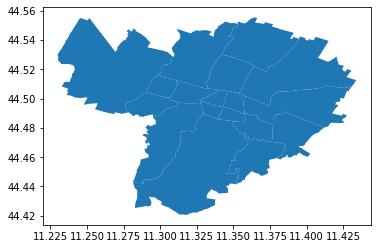

In [3]:
## here a map of Bologna!

map_df.plot()

### Now, I'm going to take all my csv files, doing some spaghetti code to pre-process them and make them consistent to each other. Of course, using only Inside Airbnb data should make this process less annoying.

In [4]:
# all my csv!
files = [i for i in os.listdir('listings') if i.endswith('.csv')]

# Initializing all csv files as a pandas dataframe
dfs = []
for i in files:  
    try:
        dfs.append(pd.read_csv("listings/" + i, error_bad_lines=False))
    except UnicodeDecodeError:
        print(i)

# Normalizing column spelling across different dataframes    
for df in dfs:
    if "neighborhood" in df.columns:
        df["neighbourhood"] = df.neighborhood
        del df["neighborhood"]
    if "lat" in df.columns:
        df["latitude"] = df.lat
        del df["lat"]
    if "lng" in df.columns:
        df["longitude"] = df.lng
        del df["lng"]
    if "lon" in df.columns:
        df["longitude"] = df.lon
        del df["lon"]
        
        
# Getting rid of datasets with non-float lat-long annotations
tmp = [(dfs[i], files[i]) for i in range(len(dfs)) if isinstance(dfs[i].latitude[0], float)]
dfs = [i[0] for i in tmp]
files = [i[1] for i in tmp]


# Creating a list of pandas datetimes from the filenames        
periods = []
for i in files:
    y = i.split(".")[0].split("_")[1]
    m = i.split(".")[0].split("_")[0]
    d = 1
    date = str(y) + "-" + str(m) + "-" + str(d)
    date = pd.Timestamp(date)
    periods.append(date)

    
# Sorting dataframes by date
tmp = [(d,p) for d,p in sorted(zip(dfs,periods), key=lambda pair: pair[1])]
periods = [b for a,b in tmp]
dfs = [a for a,b in tmp]
    
    
## then check out if everything went well 
assert(len(periods) == len(dfs))

### Ok, my datasets are ready to be visualized. But before, I have to check out every single announce coordinates and place it in its corresponding district polygon (the column "geometry" up here). To do that, I used shapefile along with shapely.

In [5]:
shp = open(shp, "rb")
dbf = open("gis_data/zone_RM40.dbf", "rb")

r = shapefile.Reader(shp=shp, dbf=dbf)
allrecords = r.records()
allshapes = r.shapes()

### Once all the polygons are correctly read by shapefile, we can make the placement of every house announce and create a new column for each dataset, called "zone". This piece of code can take several minutes. 

In [6]:
for df in dfs[-2:]:    
    zone = []
    for j in range(len(df)):
        try:
            point = df.longitude[j], df.latitude[j]
            zone.append(None)
        except AttributeError:
            print(df)
    
        for i in range(len(allshapes)):
            rec=(Point(point).within(shape(allshapes[i])), allrecords[i])
            if rec[0] == True:
                zone = zone[:-1]
                zone.append(rec[-1][-1])
    
    df["zone"] = zone
    
dfs[-1][["id", "name", "zone", "neighbourhood"]].sample(5)

,id,name,zone,neighbourhood
2908,51337855,Tagliacozzi Suite,Murri,Santo Stefano
139,2486018,Live in history: loft with frescos,Marconi,Porto - Saragozza
1860,34226328,Bilocale di design con PARCHEGGIO Privato,San Donato,San Donato - San Vitale
647,14868806,"Appartamento di fronte ad Ospedale Sant'Orsola,",Irnerio,Santo Stefano
3274,568130870158397355,THE Japanese Loft Room,Irnerio,Santo Stefano


### Next, I wrote some function to create a dynamic heatmap, which is actually one heatmap per each timeframe following each other. The function "geomerge" merges the announces count per zone to the Bologna geomap:

In [7]:
def geomerge(df):
    merged = map_df.set_index("NOMEZONA").join(df.zone.value_counts().rename("id_per_zone"))
    return merged

geomerge(dfs[-1]).sample(5)

,AREA,PERIMETER,CODZONA,NUMQUART,geometry,id_per_zone
NOMEZONA,,,,,,
S. Vitale,1.080392e+07,20385.863,T,7,"POLYGON ((11.42125 44.50770, 11.42211 44.50763...",255
Borgo Panigale,2.616634e+07,27871.663,C,1,"POLYGON ((11.25157 44.55506, 11.25300 44.55319...",75
S. Ruffillo,5.712906e+06,15301.515,R,9,"POLYGON ((11.35963 44.47394, 11.35966 44.47390...",42
Costa Saragozza,1.073894e+07,20089.927,F,8,"POLYGON ((11.31930 44.49630, 11.31939 44.49630...",127
Colli,2.506587e+07,30415.039,D,6,"POLYGON ((11.34649 44.48495, 11.34752 44.48482...",83


### The "binning" function uses mapclassify to create a range scale of values that will be mapped to colors by geopandas: this expedient lets heatmaps communicate to each other, in order to create a consistent colors scale.  

In [8]:
# There are a bunch of mapclassify methods: I used the "Quantiles" one. If none of those produces the map you want, 
# you can try writing yourself the bins as a list of 5 values, and pass it as argument to the function.

def binning(b=None, dfs=dfs):    
    
    if b is None:
        a = [geomerge(df) for df in dfs]
        b = [a[i].id_per_zone for i in range(len(a))]
        c = pd.concat(b)
        bins = mapclassify.Quantiles(c).bins
        return list(bins)
    else: 
        if len(b) == 5:
            return b
        else:
            raise ValueError('argument should be a list of five values (as the nb of color nuances in the heatmap)')

            
# And here we are, The geopandas heatmap, using red tones ("cmap" argument):

def dynamic_heatmap(merged, period):
    
    fig, ax = plt.subplots(1, figsize=(16, 12))
    merged.plot(column="id_per_zone", cmap="Reds", linewidth=0.8, ax=ax, edgecolor="0.8", scheme="user_defined"
                , classification_kwds={'bins':binning()})
    
    # matplotlib annotations...
    ax.axis("off")
    ax.set_title("Numero assoluto annunci per zona", fontdict={"fontsize": "15", "fontweight" : "3"})
    ax.annotate(period.strftime('%Y/%m'),xy=(0.1, .2),  xycoords="figure fraction"
                ,horizontalalignment="left", verticalalignment="top", fontsize=15, color="#555555")
    
    # and the caption..
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=3, vmax=781))
    cbar = fig.colorbar(sm)
    
    plt.show()
    plt.pause(1)
    # flushing the heatmap after one second pause
    clear_output(wait=True)

### And voilà, a nice slide presentation of Airbnb impact on Bologna districts, that can possibly become a gif, easily embeddable everywhere.

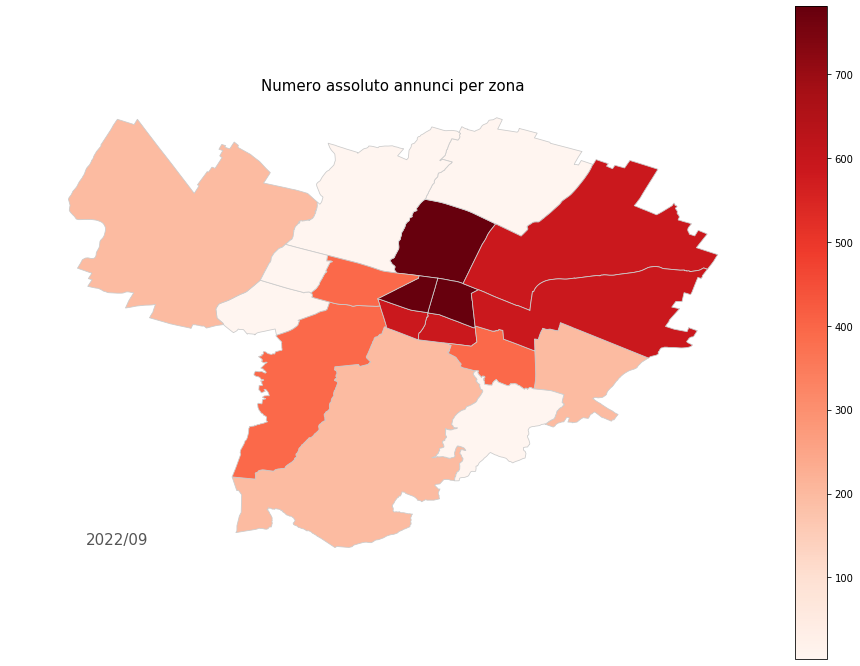

In [9]:
for ix,df in enumerate(dfs):
    dynamic_heatmap(geomerge(df), periods[ix])
    time.sleep(1)

In [10]:
# I want to stock my new georeferenced data for using it afterward, so I overwrite my old csvs with the new ones. 
# please comment this cell out if you don't want that

for ix, df in enumerate(dfs):
    
    y = periods[ix].year
    m = periods[ix].month
    
    df.to_csv(f'listings/{m}_{y}.csv')